In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time

In [2]:
zip_file_path = './task2.zip'
extraction_directory = 'extracted_images/'

In [3]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train.to_numpy()

In [4]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

In [5]:
def replicate_row(row):
    # Find the length of the non-NaN part
    valid_length = np.argmax(row.isna())
    valid_length = valid_length if valid_length > 0 else len(row)

    # Repeat the non-NaN part and truncate to match the original length
    repeated = np.tile(row[:valid_length], len(row) // valid_length + 1)[:len(row)]
    return pd.Series(repeated)

start = time.time()

X_train_periodic = X_train.apply(replicate_row, axis=1)

end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 1.011091947555542 seconds


In [6]:
X_train_periodic_np = X_train_periodic.to_numpy()

In [7]:
from numpy.random import RandomState

prng = RandomState(1)

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    signal = signal.copy()
    # Time Shifting
    if max_shift > 0:
        shift = prng.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        signal *= prng.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)

    # Adding Noise
    if noise_level > 0:
        signal += pd.DataFrame(prng.normal(0, noise_level, size=signal.size + 500)).rolling(window=500).median().to_numpy().squeeze()[500:]

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = prng.uniform(1 - max_freq_change, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        if freq_change > 1:
            signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]
        elif freq_change < 1:
            signal = np.tile(np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal), 2)[:signal.size]
    return signal


In [8]:
class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution[name] , class_distribution[name] / y_train_np.size))
print('')

y_train_np = y_train.to_numpy().squeeze()

# Parameters for augmentation
max_shift = 450  # Maximum shift for time shifting
scaling_factor_range = 0.05  # Scaling factor range for scaling
noise_level = 1500  # Noise level for adding noise
max_freq_change = 0.01  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label in [1]*4 + [2]*1 + [3]*12:
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:  # Define your threshold
            augmented_signal = augment_signal(X_train_periodic_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# Convert augmented data to numpy arrays and add to original dataset
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_periodic_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution_extended:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution_extended[name], class_distribution_extended[name] / y_train_extended_np.size))

Original:
0: 3030 = 59.21%
1: 443 = 8.66%
2: 1474 = 28.81%
3: 170 = 3.32%

Extended:
0: 3030 = 29.13%
1: 2215 = 21.29%
2: 2948 = 28.34%
3: 2210 = 21.24%


In [9]:
# Retrieve one sample recording per class for plotting
num_classes = 4
num = 10
offset = 0
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(X_train.index[np.argwhere(y_train['y'].to_numpy() == class_id)[offset:offset+num].squeeze().tolist()].to_list())
    
# Print indices of the sample signals
sample_signal_ids

[[0, 1, 2, 6, 9, 11, 12, 13, 15, 19],
 [3, 5, 7, 16, 29, 53, 77, 96, 108, 113],
 [4, 8, 10, 14, 17, 18, 20, 22, 26, 28],
 [30, 33, 71, 74, 102, 103, 171, 197, 201, 269]]

In [10]:
# Retrieve one sample recording per class for plotting
num_classes = 4
num = 10
offset = 0
sample_signal_ids_last = []
for class_id in range(num_classes):
    sample_signal_ids_last.append(X_train.index[np.argwhere(y_train['y'].to_numpy() == class_id).squeeze().tolist()[-offset-num-1:-offset-1]].to_list())
    
# Print indices of the sample signals
sample_signal_ids_last

[[5100, 5102, 5104, 5105, 5106, 5107, 5108, 5109, 5113, 5114],
 [4971, 4974, 5027, 5051, 5064, 5078, 5084, 5094, 5097, 5103],
 [5058, 5068, 5073, 5080, 5082, 5085, 5089, 5098, 5101, 5111],
 [4904, 4907, 4940, 4950, 4969, 4973, 4980, 5013, 5031, 5036]]

In [11]:
# Retrieve one sample recording per class for plotting
num_classes = 4
num = 10
offset = 0
sample_signal_ids_extended_last = []
for class_id in range(num_classes):
    sample_signal_ids_extended_last.append(X_train_extended.index[np.argwhere(y_train_extended['y'].to_numpy() == class_id).squeeze().tolist()[-offset-num-1:-offset-1]].to_list())
    
# Print indices of the sample signals
sample_signal_ids_extended_last

[[5100, 5102, 5104, 5105, 5106, 5107, 5108, 5109, 5113, 5114],
 [6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887],
 [8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361],
 [10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401]]

num = 10
fig, axs = plt.subplots(4*num, 1, figsize=(45, 30*num))
plot_length = 1000
seconds = np.arange(0, plot_length) / 150
x_labels = range(0,int(seconds[-1]),3)

for class_id in range(4):
    for i in range(num):
        ax = axs[num*class_id + i]
        ax.set_title("Class {}".format(class_id))
        ax.plot(seconds, X_train_extended_np[sample_signal_ids_extended_last[class_id][i], 0:plot_length:1], color='g', label='modified')
        ax.plot(seconds, X_train_np[sample_signal_ids_last[class_id][i], 0:plot_length:1], color='k', label='original')
        ax.set_xticks(x_labels)
        ax.legend()
        ax.grid()
fig.tight_layout()

ax = fig.add_subplot(111, frameon=False)
plt.show()

In [ ]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# ms_flt_array = [0.2,0.6]
ms_flt_array = [0.4,0.8]

def filter_line(data, ms_flt_array):
    data = data.copy()

    for i in range(0, len(ms_flt_array)):
        window_size = get_median_filter_width(300, ms_flt_array[i])

        data -= data.apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median(), axis=1)

    return data

X_train_filtered = filter_line(X_train_extended, ms_flt_array)
X_train_filtered_np = X_train_filtered.to_numpy()

In [ ]:
total_length = X_train.shape[1]

def denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    # Decompose to get the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate the frequency bands for each level of decomposition
    freqs = pywt.scale2frequency(wavelet, [1, 2, 4, 8, 16, 32, 64]) * sampling_rate

    # Calculate a universal threshold
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply selective thresholding
    new_coeffs = []
    for i, coeff in enumerate(coeffs[1:], start=1):  # Skip the approximation coefficients
        if freqs[i-1] >= qrs_band[0] and freqs[i-1] <= qrs_band[1]:
            # If within QRS band, apply a softer threshold or skip thresholding
            new_coeffs.append(pywt.threshold(coeff, value=threshold/dampening, mode='soft'))
        else:
            # Else, apply the regular threshold
            new_coeffs.append(pywt.threshold(coeff, value=threshold, mode='soft'))
    
    # Reconstruct the signal using modified coefficients
    coeffs[1:] = new_coeffs
    return pywt.waverec(coeffs, wavelet)

def process_signal(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    global total_length
    # Find the index of the first NaN value
    nan_index = np.argmax(np.isnan(signal))
    if nan_index == 0:  # No NaNs found
        return denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening)
    
    a = np.empty((total_length-nan_index,))
    a[:] = np.nan

    return np.concatenate([denoise_signal_with_selective_thresholding(signal[:nan_index], wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening), a])[0:total_length]

In [ ]:
wavelet = 'db4'  # Example wavelet, choose as per your requirement
level = 3 # Decomposition level
qrs_band = (50, 150)  # Frequency band of QRS complex in Hz
sampling_rate = 300  # Sampling rate of ECG signal in Hz
dampening = 1

X_train_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_train_filtered_np])
X_train_denoised = pd.DataFrame(data=X_train_denoised_np, columns=X_train_extended.columns, index=X_train_extended.index)

In [ ]:
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
import biosppy.signals.ecg as ecg

# from sklearn.preprocessing import RobustScaler, StandardScaler

In [ ]:
def normalize_signal(signal):

    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    vals_peaks = signal[r_peaks]
    median_peak_val = np.median(vals_peaks[~np.isnan(vals_peaks)])
    
    if median_peak_val != 0:
        if np.isnan(median_peak_val).any():
            print(median_peak_val)
        return signal / median_peak_val
    # else:
    #     print(median_peak_val)
    #     return RobustScaler(quantile_range=(.2,.8)).fit_transform(signal.T).T/5

X_train_transformed_np = np.apply_along_axis(normalize_signal, 1, X_train_denoised_np)
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train_denoised.columns, index=X_train_denoised.index)

In [ ]:
def plot_features(signal):
    
    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, label='Median HeartBeat', color='#CC4F1B')
            plt.legend()

In [ ]:
plt.figure(figsize=(30, 5*num))

for class_id in range(num_classes):
    for i in range(num):
        ax = plt.subplot( num, 4, class_id + 4*i + 1)
        ax.set_title("Class {}".format(class_id))
        if class_id:
            ax.set_yticks([])
        # ax.set_ylim([-700, 1500])
        ax.grid()
        plot_features(X_train_transformed.loc[sample_signal_ids[class_id][i]].to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30, 5*num))

for class_id in range(num_classes):
    for i in range(num):
        ax = plt.subplot( num, 4, class_id + 4*i + 1)
        ax.set_title("Class {}".format(class_id))
        if class_id:
            ax.set_yticks([])
        # ax.set_ylim([-700, 1500])
        ax.grid()
        plot_features(X_train_transformed.loc[sample_signal_ids_extended_last[class_id][i]].to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30, 5*num))

for class_id in range(num_classes):
    for i in range(num):
        ax = plt.subplot( num, 4, class_id + 4*i + 1)
        ax.set_title("Class {}".format(class_id))
        if class_id:
            ax.set_yticks([])
        # ax.set_ylim([-700, 1500])
        ax.grid()
        plot_features(X_train_transformed.loc[sample_signal_ids_last[class_id][i]].to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

xlim = (0,18000)

class_to_show = 3

indeces = sample_signal_ids_extended_last[class_to_show]

processed_arr = X_train_transformed_np[indeces]

for i, j in enumerate(indeces):

    processed = processed_arr[i]

    detectors = Detectors(300)

    r_peaks_pan_proc = correct_rpeaks(processed, np.asarray(detectors.pan_tompkins_detector(processed)), 300, .2)['rpeaks']

    plt.figure(figsize=(21, 7*len(indeces)))
    
    plt.subplot(len(indeces), 1, i+1)
    plt.plot(processed, label='Denoised Signal', color='black', alpha=.6)
    plt.vlines(r_peaks_pan_proc, ymin=-2, ymax=2, colors = ['red'], alpha=.4)
    plt.xlim(xlim)
    plt.ylim((-1.5,1.5))
    plt.legend()
    plt.grid()
    plt.tight_layout()
plt.show()

def compute_heart_rate(signal, window_fraction=1/5):
    """
        window_fraction: only divisors of 180000
    """

    if isinstance(signal, pd.DataFrame):
        signal = signal.to_numpy()
    
    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    a = np.zeros_like(signal)
    
    a[r_peaks] = 1

    window = int(300*60*window_fraction)

    return (pd.DataFrame(a).rolling(window=window, min_periods=1).sum() / window_fraction).iloc[window:]

a = compute_heart_rate(X_train_transformed.iloc[sample_signal_ids_extended_last[3][1]])
plt.plot(a);
plt.hlines(a.describe()[0][[1,3,4,5,6,7]].to_numpy(), 0, 18000);

In [ ]:
def extract_features(signal):
    
    r_peaks = correct_rpeaks(signal, np.asarray(Detectors(300).pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.4, after=.4)['templates']

    if len(beats) == 0:
        raise Exception()

    a = np.zeros_like(signal)    
    a[r_peaks] = 1

    # continuous features
    
    mu = np.mean(beats, axis=0) 
    var = np.std(beats, axis=0)
    quant_001 = np.quantile(beats, q=.001, axis=0)
    quant_05 = np.quantile(beats, q=.05, axis=0)
    quant_1 = np.quantile(beats, q=.1, axis=0)
    quant_25 = np.quantile(beats, q=.25, axis=0)
    md = np.median(beats, axis=0)
    quant_75 = np.quantile(beats, q=.75, axis=0)
    quant_9 = np.quantile(beats, q=.9, axis=0)
    quant_95 = np.quantile(beats, q=.95, axis=0)
    quant_999 = np.quantile(beats, q=.999, axis=0)

    return np.array([mu, var, quant_001, quant_05, quant_1, quant_25, md, quant_75, quant_9, quant_95, quant_999]).T

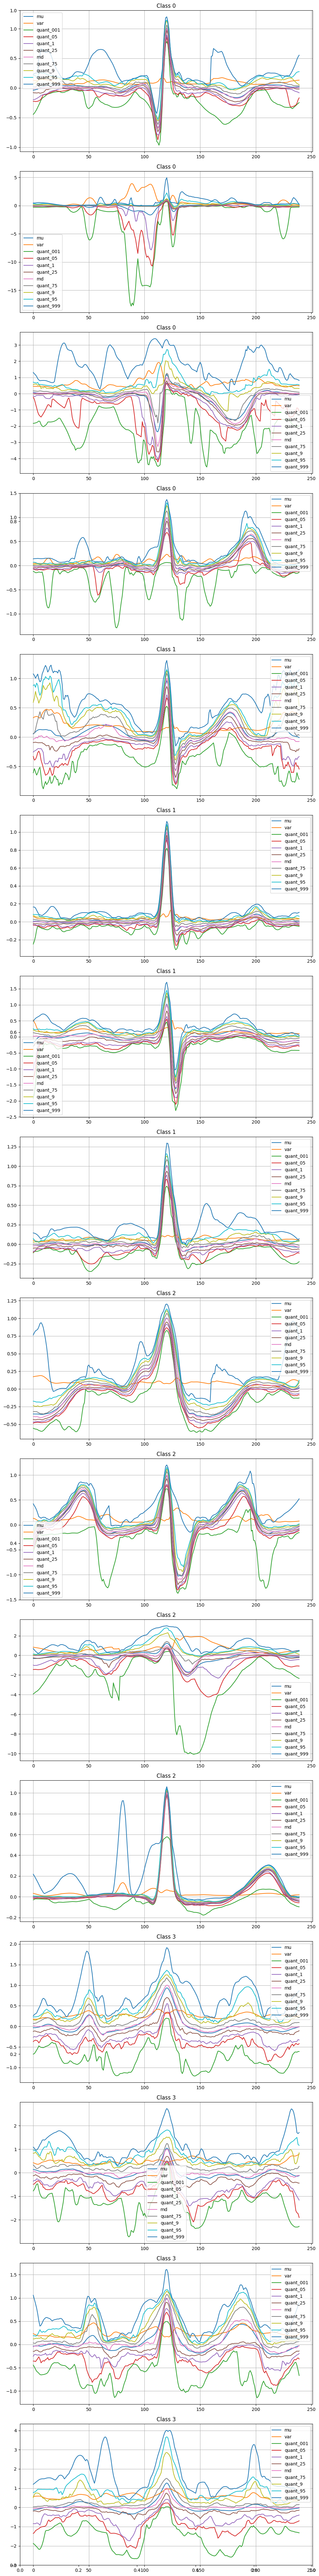

In [ ]:
num = 4
fig, axs = plt.subplots(4*num, 1, figsize=(10, 20*num))
names = ['mu', 'var', 'quant_001', 'quant_05', 'quant_1', 'quant_25', 'md', 'quant_75', 'quant_9', 'quant_95', 'quant_999']

for class_id in range(4):
    for i in range(num):
        ax = axs[num*class_id + i]
        ax.set_title("Class {}".format(class_id))
        ax.plot(extract_features(X_train_transformed_np[sample_signal_ids_last[class_id][i]]), label=names)
        ax.legend()
        ax.grid()
fig.tight_layout()

ax = fig.add_subplot(111, frameon=False)
plt.show()

In [ ]:
def extract_features(signal, window_fraction=1/5):
    
    r_peaks = correct_rpeaks(signal, np.asarray(Detectors(300).pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

    if len(beats) == 0:
        raise Exception()

    a = np.zeros_like(signal)    
    a[r_peaks] = 1
    window = int(300*60*window_fraction)

    heart_rate = (pd.DataFrame(a).rolling(window=window, min_periods=1).sum() / window_fraction).iloc[window:].to_numpy()

    # discrete features

    peak_count = r_peaks.size

    peak_mu = np.mean(signal[r_peaks])
    peak_std = np.std(signal[r_peaks])
    peak_md = np.median(signal[r_peaks])
    peak_q1 = np.quantile(signal[r_peaks], q=.1)
    peak_q25 = np.quantile(signal[r_peaks], q=.25)
    peak_q75 = np.quantile(signal[r_peaks], q=.75)
    peak_q9 = np.quantile(signal[r_peaks], q=.9)

    heart_rate_mu = np.mean(heart_rate)
    heart_rate_std = np.std(heart_rate)
    heart_rate_md = np.median(heart_rate)
    heart_rate_q1 = np.quantile(heart_rate, q=.1)
    heart_rate_q25 = np.quantile(heart_rate, q=.25)
    heart_rate_q75 = np.quantile(heart_rate, q=.75)
    heart_rate_q9 = np.quantile(heart_rate, q=.9)

    # continuous features
    
    # mu = np.mean(beats, axis=0) 
    # var = np.std(beats, axis=0)
    # md = np.median(beats, axis=0)

    # quant_1 = np.quantile(beats, q=.1, axis=0)
    # quant_25 = np.quantile(beats, q=.25, axis=0)
    # quant_75 = np.quantile(beats, q=.75, axis=0)
    # quant_9 = np.quantile(beats, q=.9, axis=0)

    return np.array([peak_count,
             peak_mu, peak_std, peak_md, peak_q1, peak_q25, peak_q75, peak_q9,
             heart_rate_mu, heart_rate_std, heart_rate_md, heart_rate_q1, heart_rate_q25, heart_rate_q75, heart_rate_q9])
             # np.ndarray([[mu, var, md, quant_1, quant_25, quant_75, quant_9]])]

NameError: name 'jjjj' is not defined

In [ ]:
X_train_discrete_features_np = np.array([extract_features(row) for row in X_train_transformed_np])

In [ ]:
# Downscaling
X_train_downsampled_np = X_train_transformed_np[:,:-1:2]
X_train_downsampled = pd.DataFrame(X_train_downsampled_np)

In [ ]:
X_train_ready_np = np.concatenate([X_train_downsampled_np, X_train_discrete_features_np], axis=1)
X_train_ready = pd.DataFrame(X_train_ready_np)

In [ ]:
X_train_ready_np.shape, X_train_downsampled_np.shape, X_train_discrete_features_np.shape

((10403, 8918), (10403, 8903), (10403, 15))

# OBTAIN TEST DATA

In [ ]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_periodic = X_test.apply(replicate_row, axis=1)
X_test_periodic_np = X_test_periodic.to_numpy()

X_test_filtered = filter_line(X_test_periodic, ms_flt_array)
X_test_filtered_np = X_test_filtered.to_numpy()

X_test_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_test_filtered_np])
X_test_denoised = pd.DataFrame(data=X_test_denoised_np, columns=X_test.columns, index=X_test.index)

X_test_transformed_np = np.apply_along_axis(normalize_signal, 1, X_test_denoised_np)
X_test_transformed = pd.DataFrame(data=X_test_transformed_np, columns=X_test.columns, index=X_test.index)

X_test_discrete_features_np = np.array([extract_features(row) for row in X_test_transformed_np])

X_test_downsampled_np = X_test_transformed_np[:,:-1:2]
X_test_downsampled = pd.DataFrame(X_test_downsampled_np)

X_test_ready_np = np.concatenate([X_test_downsampled_np, X_test_discrete_features_np], axis=1)
X_test_ready = pd.DataFrame(X_test_ready_np)


In [ ]:
X_train_ready.shape, X_test_ready.shape

((10403, 8918), (3411, 8918))

# MODEL TRAINING

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate, GlobalAveragePooling1D, Activation
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras.layers import Input, concatenate
from keras.models import Model

/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_ready_np, y_train_cat_np, test_size=0.2, random_state=23)

In [ ]:
dropout = 0.3
dropout_CNN = .4
dropout_LSTM = .3

In [ ]:
# CNN part
input_shape_cnn = (X_train_ready_np[:,:-15].shape[1], 1)
cnn_input = Input(shape=input_shape_cnn)
num_discrete_features = X_train_discrete_features_np.shape[1]

x = cnn_input
for _ in range(5):
    x = Conv1D(64, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropout_CNN)(x)

x = GlobalAveragePooling1D()(x)

extra_features_input = Input(shape=(num_discrete_features,))

# Combine CNN output and extra features
combined = concatenate([x, extra_features_input])

# FCN part
fc_neurons = [128, 128, 128, 64]
for neurons in fc_neurons:
    combined = Dense(neurons, activation='relu')(combined)
    combined = Dropout(dropout)(combined)

# Output layer
output = Dense(4, activation='softmax')(combined)

# Create the model
model = Model(inputs=[cnn_input, extra_features_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8903, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 8903, 64)             384       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 4451, 64)             0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 4451, 64)             0         ['max_pooling1d[0][0]']   

In [ ]:
start = time.time()
History = model.fit([X_train_partial[:,:-num_discrete_features], X_train_partial[:,-num_discrete_features:]],
                    y_train_partial,
                    epochs=500,
                    batch_size=1024,
                    validation_split=0.0,
                    validation_data=([X_val[:,:-num_discrete_features], X_val[:,-num_discrete_features:]], y_val),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)
model.save("model_CNN_with_discrete_features.keras")

Epoch 1/500
9/9 [==============================] - 38s 4s/step - loss: 7.4032 - accuracy: 0.2603 - val_loss: 1.4481 - val_accuracy: 0.3099
Epoch 2/500
9/9 [==============================] - 38s 4s/step - loss: 2.7452 - accuracy: 0.2549 - val_loss: 1.3371 - val_accuracy: 0.3359
Epoch 3/500
9/9 [==============================] - 38s 4s/step - loss: 1.6883 - accuracy: 0.2805 - val_loss: 1.3507 - val_accuracy: 0.3421
Epoch 4/500
9/9 [==============================] - 38s 4s/step - loss: 1.4311 - accuracy: 0.2894 - val_loss: 1.3564 - val_accuracy: 0.3316
Epoch 5/500
9/9 [==============================] - 38s 4s/step - loss: 1.3823 - accuracy: 0.2948 - val_loss: 1.3443 - val_accuracy: 0.3940
Epoch 6/500
9/9 [==============================] - 37s 4s/step - loss: 1.3608 - accuracy: 0.3246 - val_loss: 1.3399 - val_accuracy: 0.4080
Epoch 7/500
9/9 [==============================] - 37s 4s/step - loss: 1.3449 - accuracy: 0.3408 - val_loss: 1.3302 - val_accuracy: 0.3878
Epoch 8/500
9/9 [==========

3/3 [==============================] - 4s 1s/step - loss: 0.5741 - accuracy: 0.7597
-----------------------------------------------------------------
train accuracy = 79.38%
test accuracy = 75.9731%


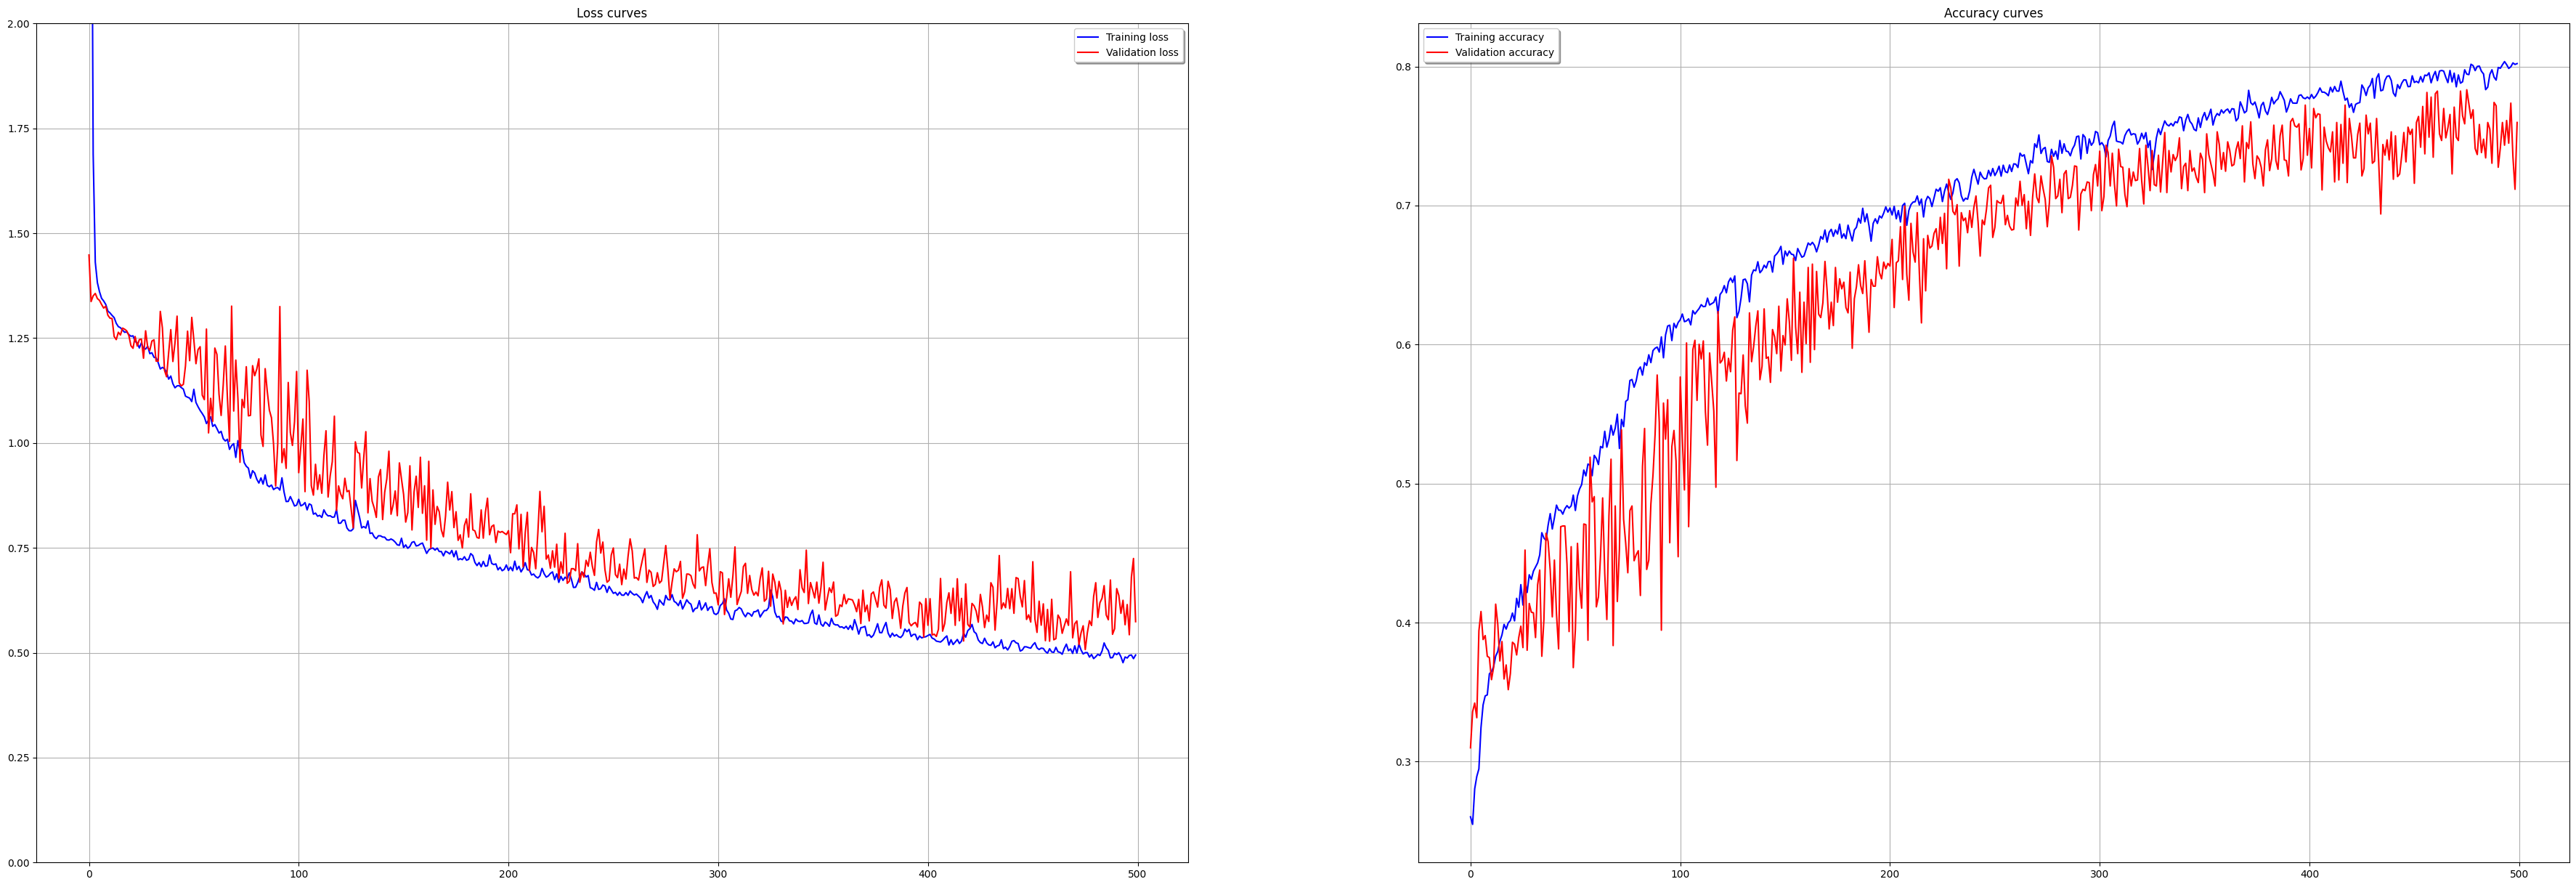

66/66 [==============================] - 3s 43ms/step
0.7597308986064392


In [ ]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate([X_train_partial[:,:-num_discrete_features], X_train_partial[:,-num_discrete_features:]],
                                       y_train_partial,
                                       batch_size=1024,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate([X_val[:,:-num_discrete_features], X_val[:,-num_discrete_features:]],
                                                    y_val,
                                                    batch_size=1024,
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].set_ylim((0,2))
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict([X_val[:,:-num_discrete_features], X_val[:,-num_discrete_features:]])
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict([X_test_ready_np[:,:-num_discrete_features], X_test_ready_np[:,-num_discrete_features:]])

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_bigger.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 5s 42ms/step


In [ ]:
jjjj

In [ ]:
# Model parameters
input_shape = (X_train_partial.shape[1], 1)  # Replace 'None' with your input length
num_classes = 4
dropout_rate = 0.3
dropout = .3
recurrent_dropout = .4

model = Sequential()

model.add(LSTM(input_shape=input_shape,
            units=32,
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            return_sequences=True,
            return_state=False,
            stateful=False,
            unroll=False
            ))
model.add(BatchNormalization())
model.add(LSTM(units=32,
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            return_sequences=True,
            return_state=False,
            stateful=False,
            unroll=False
            ))
model.add(BatchNormalization())

fc_neurons = [64, 64, 32]
for neurons in fc_neurons:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

# Softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=50,
                    batch_size=1024,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)
model.save("model_LSTM.keras")

1/1 [==============================] - 2s 2s/step - loss: 0.3024 - accuracy: 0.9005
-----------------------------------------------------------------
train accuracy = 96.035%
test accuracy = 90.0461%


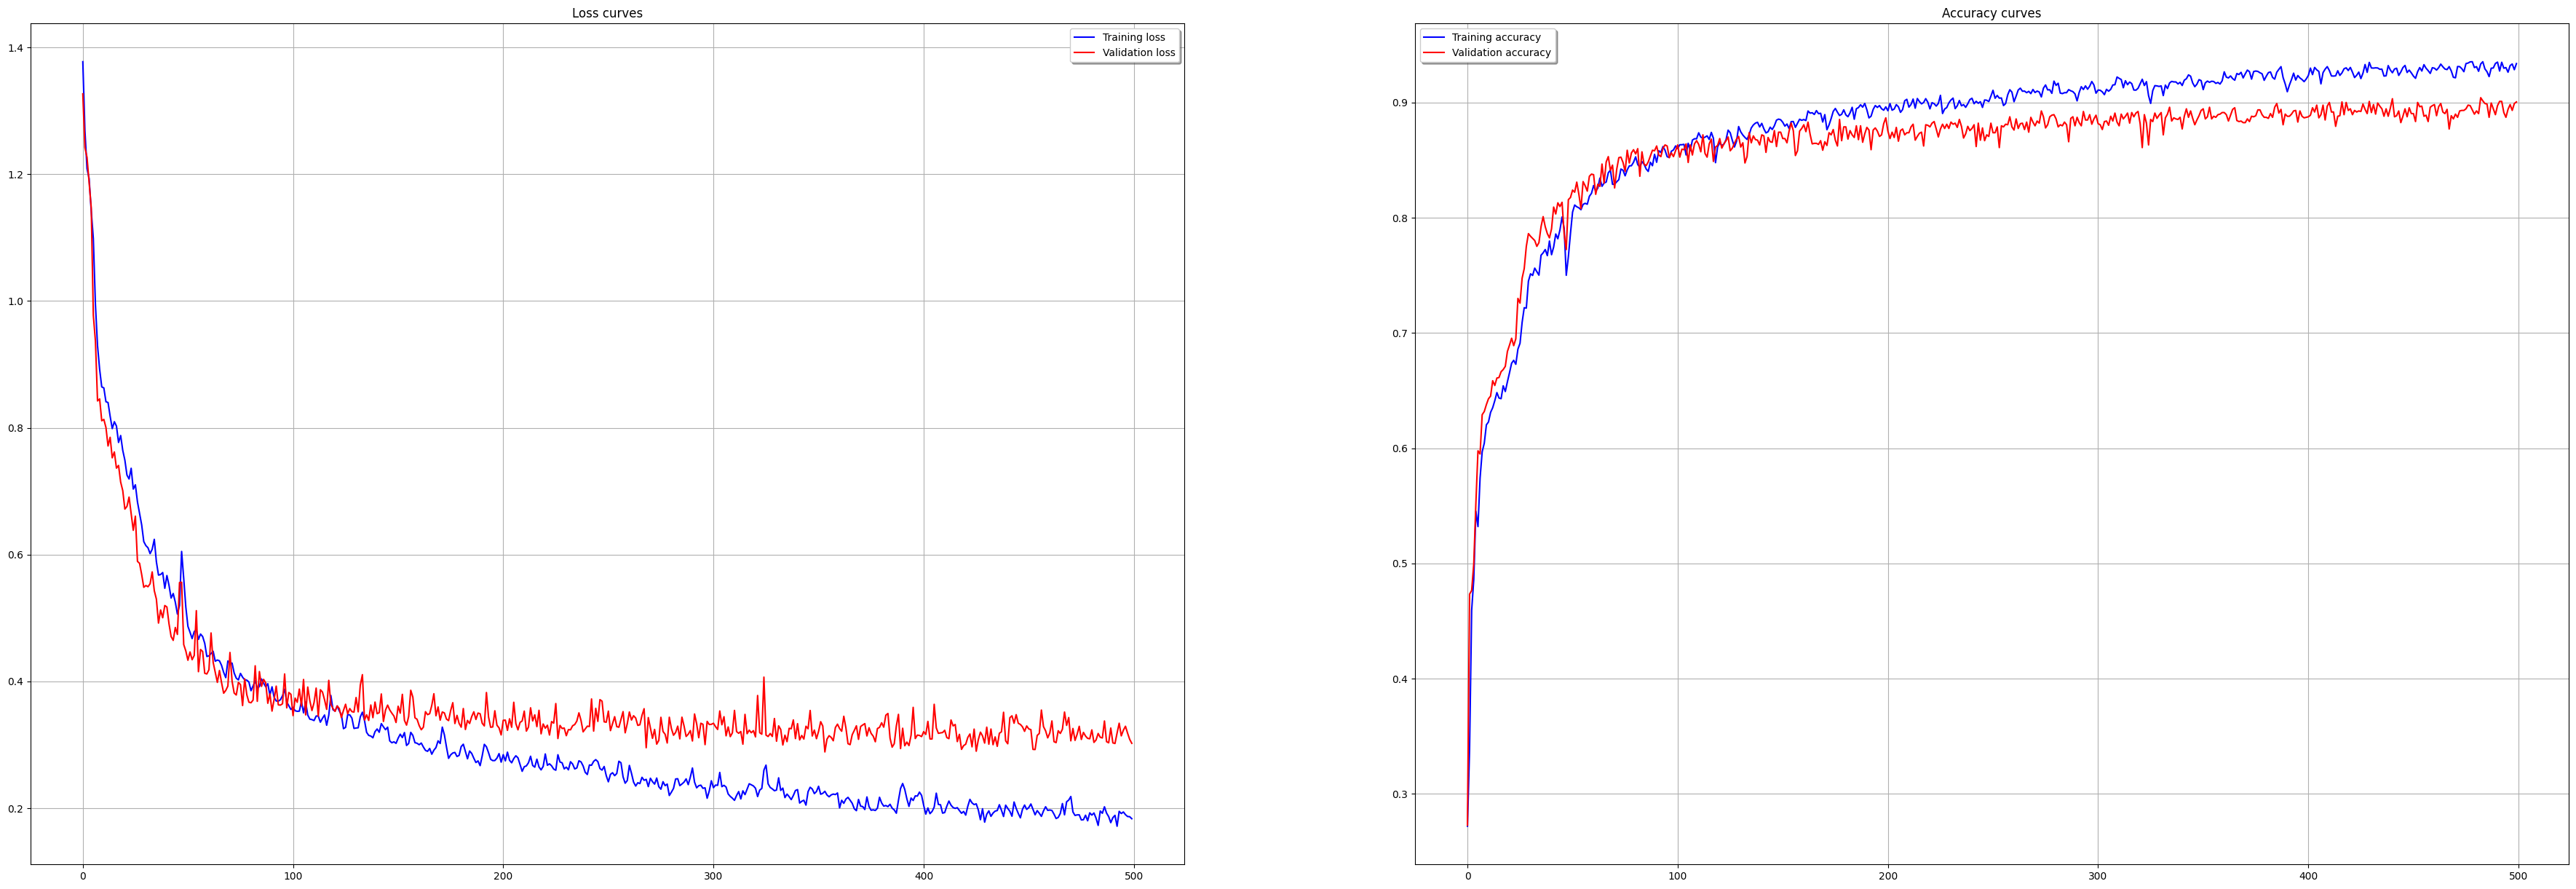

68/68 [==============================] - 3s 38ms/step
0.9004608294930876


In [ ]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_bigger.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 4s 39ms/step


In [ ]:
class_distribution_pred = y_test_pred_class.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']

print('Original:')
for name in class_distribution:
    print(str(name) + ': {:2.1%}'.format(class_distribution[name] / y_train.size))
print('')
print('Pred:')
for name in class_distribution_pred:
    print(str(name) + ': {:2.1%}'.format(class_distribution_pred[name] / y_test_pred_class.shape[0]))

Original:
0: 59.2%
1: 8.7%
2: 28.8%
3: 3.3%

Pred:
0: 63.1%
1: 11.0%
2: 23.7%
3: 2.1%


In [ ]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=5,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100,
                           verbose=1,
                           mode='max',
                           baseline=0.8,
                           start_from_epoch=1,
                           restore_best_weights=True)

callbacks=[lr_decay, early_stop]